**Piotr Duszak - praca domowa 3 - wykorzystanie metody lime na przykładzie wyznaczania ceny domów**

W niniejszym notebooku będzie testowana metoda lime do sprawdzenia, jak duży wpływ ma dana zmienna na predykcję modelu. Wykorzystano dane dotyczące nieruchomości (na wejściu są informacje takie jak liczba sypialni, liczba łazienek, metraż, współrzędne geograficzne, itp., a model ma przewidzieć jego cenę).

Wykorzystano dwa modele. Jeden z nich to random forest (przy użyciu biblioteki sklearn), a drugi to maszyna wektorów nośnych (przy użyciu biblioteki sklearn).

Fragmenty niedotyczące lime'a są w sporej mierze przekopiowane z mojej drugiej pracy domowej, ale dla spójności pracy tutaj również są zamieszczone.

# Wczytywanie danych

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
# Wczytanie danych
hous_data = pd.read_csv('drive/MyDrive/kc_house_data.csv')
# Zamiana daty ze stringa na datę
hous_data['date'] = hous_data['date'].apply(lambda x: datetime.strptime(x, '%Y%m%dT%H%M%S').date())
hous_data.columns = hous_data.columns.str.replace(' ', '_')
hous_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Dane składają się z 21613 rekordów. W każdym są następujące informacje: 
* Id: unikalny identyfikator każdego sprzedanego domu
* Date: data sprzedaży domu
* Price: cena każdego sprzedanego domu
* Bedrooms: liczba sypialni
* Bathrooms: liczba łazienek, gdzie 0,5 odpowiada pokojowi z toaletą, ale bez prysznica
* Sqft_living: powierzchnia wnętrza mieszkania
* Sqft_lot: powierzchnia działki
* Floors: liczba pięter
* Waterfront: zmienna określająca, czy mieszkanie wychodziło na nabrzeże, czy nie
* View: indeks od 0 do 4 pokazujący, jak dobry był widok z nieruchomości
* Condition: indeks od 1 do 5 na temat stanu mieszkania
* Grade: indeks od 1 do 13, oceniający jakość wykonania
* Sqft_above: powierzchnia wnętrza mieszkania, znajdującej się nad poziomem gruntu
* Sqft_basement: powierzchnia wnętrza mieszkania, znajdującej się poniżej poziomu gruntu
* Yr_built: rok, w którym dom został pierwotnie zbudowany
* Yr_renovated: rok ostatniego remontu domu
* Zipcode: kod pocztowy
* Lat: szerokość geograficzna
* Long: długość geograficzna
* Sqft_living15: powierzchnia mieszkania najbliższych 15 sąsiadów
* Sqft_lot15: powierzchnia działki 15 najbliższych sąsiadów

Z bazy danych postanowiono usunąć id i zipcode, gdyż wydaje się, że nie powinny mieć wpływu na cenę mieszkania. Datę sprzedaży rozdzielono na trzy wartości (rok, miesiąc i dzień). Poniżej zmodyfikowana baza danych z podstawowymi statystykami.

In [87]:
hous_data['year'] = hous_data['date'].apply(lambda x: x.year)
hous_data['month'] = hous_data['date'].apply(lambda x: x.month)
hous_data['day'] = hous_data['date'].apply(lambda x: x.day)
hous_data.drop(['id', 'zipcode', 'date'], axis=1, inplace=True)
hous_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,2014.322954,6.574423,15.688197
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.467616,3.115308,8.635063
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000,6.000000,16.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,9.000000,23.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000


In [88]:
# Przekonwertowanie wszystkich liczb na float, pomieszanie wierszy i rozdzielenie na zbriór uczący, testowy i walidacyjny
length = hous_data.shape[0]
hous_data = hous_data.astype(float)
hous_data = hous_data.astype({'view': int, 'condition': int, 'grade': int})
hous_data = hous_data.sample(frac=1, random_state=0).reset_index(drop=True)
train, val, test = hous_data.loc[:int(length*0.5)], hous_data.loc[int(length*0.5):int(length*0.75)], hous_data.loc[int(length*0.75):]
train_y, train_x = train['price'], train[train.columns[1:]]
val_y, val_x = val['price'], val[train.columns[1:]]
test_y, test_x = test['price'], test[train.columns[1:]]

Dane zostały podzielone na dane treningowe, walidacyjne oraz testowe (każdy zestaw na wejście oraz wyjście).

Ze względu na to, że drugim testowanym modelem będzie maszyna wektorów wspierających postanowiono od razu znormalizować dane. Co prawda ciężej wtedy oceniać pojedynczą predykcję modelu (bo wynik może być ujemny na przykład), ale równie łatwo porównywać różne predykcje oraz wpływ parametrów na predykcję. Z tych względów uznano, że cała dalsza analiza będzie na danych znormalizowanych.

In [89]:
train_x, train_y = (train_x-train_x.mean())/train_x.std(), (train_y-train_y.mean())/train_y.std()
val_x, val_y = (val_x-val_x.mean())/val_x.std(), (val_y-val_y.mean())/val_y.std()
test_x, test_y = (test_x-test_x.mean())/test_x.std(), (test_y-test_y.mean())/test_y.std()

# 1. Nauczenie modelu przy pomocy lasu losowego


In [90]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(0)
# Stworzenie i wytrenowanie modelu
tree_regressor = RandomForestRegressor(criterion='mse', max_depth=10)
tree_regressor.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Został nauczony model decyzyjny (o maksymalnej głębokości 15), a następnie zewaluowany na danych treningowych, walidacyjnych i testowych.

In [91]:
tree_train_r2 = tree_regressor.score(train_x, train_y)
tree_val_r2 = tree_regressor.score(val_x, val_y)
tree_test_r2 = tree_regressor.score(test_x, test_y)
print('Współczynnik determinacji dla zbiory treningowego {}'.format(tree_train_r2))
print('Współczynnik determinacji dla zbiory walidacyjnego {}'.format(tree_val_r2))
print('Współczynnik determinacji dla zbiory testowego {}'.format(tree_test_r2))

Współczynnik determinacji dla zbiory treningowego 0.9441895879863321
Współczynnik determinacji dla zbiory walidacyjnego 0.8352120292790165
Współczynnik determinacji dla zbiory testowego 0.8464893300231482


Dla modelu wyznaczono współczynniki determinacji (dla zbioru uczącego, walidacyjnego i treningowego), który określa jak dobrze model jest dopasowany do danych (maksymalna wartość to 1).

Jak widać po tych współczynnikach model nie jest idealny, ale powinien całkiem dobrze szacować wartość nieruchomości.

# 2. Wyznaczeni predykcji dla trzech obserwacji

In [92]:
# Wyznaczenie predykcji dla trzech elementów ze zbioru treningowego (jako, że zbiór ten był tasowany mogą to być równie dobrze 3 pierwsze).
# Przy badaniu wpływu danego parametru na predykcję modelu nie ma też szczególnie znaczenia, czy to zbiór uczący, czy testowy
observations = train_x[:3]
predictions_tree = tree_regressor.predict(observations)
observations_show = observations.append(train_x.describe().loc['mean'])
observations_show.insert(loc=0, column='price', value=(*train_y[:3], train_y.mean()))
observations_show.insert(loc=1, column='price predicted', value=(*predictions_tree, tree_regressor.predict(train_x).mean()))
observations_show

,price,price predicted,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day
0,-6.582786e-01,-0.527794,-1.536938e+00,-8.089172e-01,-7.197153e-01,-3.350613e-01,2.789987e+00,-8.635466e-02,-3.042379e-01,-6.298890e-01,-5.721040e-01,-4.444655e-01,-6.598347e-01,9.536919e-01,-2.108328e-01,1.171651e+00,-5.397596e-01,-8.199253e-01,-3.981334e-01,-6.894305e-01,1.097751e+00,1.538578e+00
1,2.789758e+00,2.968959,6.781303e-01,1.474603e+00,2.818531e+00,9.092599e-01,9.379928e-01,-8.635466e-02,-3.042379e-01,8.987906e-01,3.692435e+00,3.490098e+00,-6.598347e-01,5.753361e-01,-2.108328e-01,5.404728e-01,3.516720e-01,3.249037e+00,9.851588e-01,-6.894305e-01,4.546614e-01,-9.003448e-01
2,5.528449e-02,-0.031663,-1.536938e+00,-1.787569e+00,-7.087947e-01,-2.842332e-01,-9.140010e-01,-8.635466e-02,-3.042379e-01,-6.298890e-01,-5.721040e-01,-7.237709e-01,-1.194377e-01,-1.969966e+00,-2.108328e-01,7.988796e-01,-1.063299e+00,-8.053933e-01,-3.051537e-01,-6.894305e-01,-1.884282e-01,1.074022e+00
mean,-2.000189e-17,-0.001414,-3.559247e-16,-2.328777e-16,-1.737709e-16,-2.078766e-16,3.379467e-16,1.550347e-15,-6.419816e-16,-3.523908e-16,-6.528403e-16,-1.737195e-17,7.950006e-16,1.988200e-15,-1.221322e-15,3.108015e-13,2.653092e-12,9.249975e-17,-1.146898e-16,1.248270e-13,6.501898e-17,-1.465983e-16


Zostały wyznaczone predycje dla trzech obserwacji ze zbioru testowego. Powyżej można zobaczyć parametry dla każdego rekordu. Dodano również wiersz z wartością średnią danego parametru dla całego zbioru treningowego.

Warto również zauważyć, że predykcję dość dobrze szacują wartość rzeczywistą.

# 3. Dekompozycja modelu przy użyciu metody LIME


Poniżej dekompozycja przy użyciu metody LIME, dla obserwacji z punktu 2. Postanowiono wybierać 5 najważniejszych parametrów. Wartości wejściowe poddano dyskretyzacji, żeby móc zobaczyć ich rzeczywisty wpływ i żeby próbkowanie obserwacji w otoczeniu miało większy sens (to znaczy, żeby te nowe próbki rzeczywiście w jakiś sposób różniły się od badanej obserwacji [patrz wykład na temat lime'a strona 26])

In [93]:
# !pip install lime

In [94]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), 
                                                   feature_names=train_x.columns,
                                                   class_names=['price'],
                                                   verbose=False, 
                                                   discretize_continuous=True, 
                                                   mode='regression',
                                                   random_state=0)

,sqft_living,grade,lat,view,sqft_living15
0,-0.719715,-0.572104,1.171651,-0.304238,-0.819925


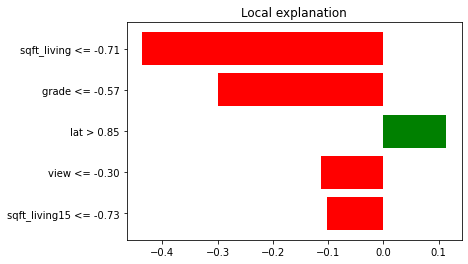

In [95]:
exp = explainer.explain_instance(train_x.loc[0], tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(train_x.loc[0, train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Dla tej predykcji najważniejsza był parametr określający powierzchnie mieszkalną. A kolejnym grade.

,lat,grade,sqft_living,sqft_living15,sqft_lot15
1,0.540473,3.692435,2.818531,3.249037,0.985159


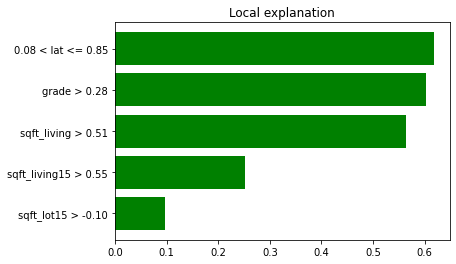

In [96]:
exp = explainer.explain_instance(train_x.loc[1], tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(train_x.loc[1, train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Dla kolejnej obserwacji najważniejsza była szerokość geograficzna, a na drugim miejscu grade.

,lat,sqft_living,grade,long,sqft_living15
2,0.79888,-0.708795,-0.572104,-1.063299,-0.805393


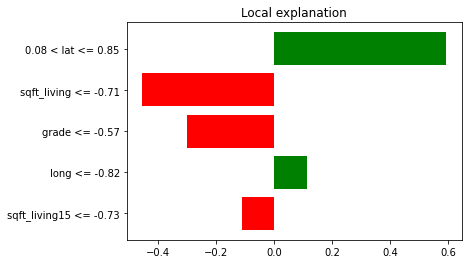

In [97]:
exp = explainer.explain_instance(train_x.loc[2], tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(train_x.loc[2, train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Tym razem również najważniejsza była szerokość geograficzna, ale na drugim miescu była powierzchnia mieszkalna.

# 4. Porównanie dekompozycji dla różnych obserwacji i badanie stabilności

Patrząc na powyższe dekompozycje wydaje się, że te same parametry mają podobny wpływ na predykcję modelu. To znaczy na przykład powierzchnia mieszkania mniejsza niż -0.71 (przypominam, że to są liczby po znormalizowaniu) ma dla dwóch powyższych przykładów podobny wpływ negatywny. Żeby mieć szerszy ogląd sytuacji postanowiono zobaczyć rozkład wpływu danego parametru dla większej liczby obserwacji.

In [98]:
exp_dict = {}
for i in train_x.index[:300]:
  exp = explainer.explain_instance(train_x.loc[i], tree_regressor.predict, num_features=5)
  exp_dict_one_obs = {el[0]:el[1] for el in exp.as_list()}
  for k, v in exp_dict_one_obs.items():
    exp_dict.setdefault(k, []).append(v)
  
exp_dict = dict(sorted(exp_dict.items(), key=lambda item: len(item[1]), reverse=True))

Poniżej rozkłady wpływu danego parametru dla dwóch tysięcy obserwacji ze zbioru treningowego.

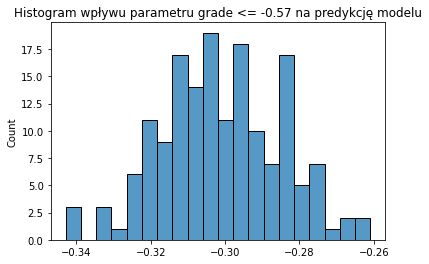

In [99]:
import seaborn as sns
keys = list(exp_dict.keys())
ax = sns.histplot(exp_dict[keys[0]], bins=20).set_title('Histogram wpływu parametru {} na predykcję modelu'.format(keys[0]))

Pierwszy wykres przedstawia rozkład wpływu parametru grade (mniejszego niż -0.57) na predykcję modelu. Jak widać dla większośći obserwacji ten parametr ma podobny wpływ.

Podobnie jest dla kolejnych trzech parametrów (wykresy można zobaczyć poniżej).

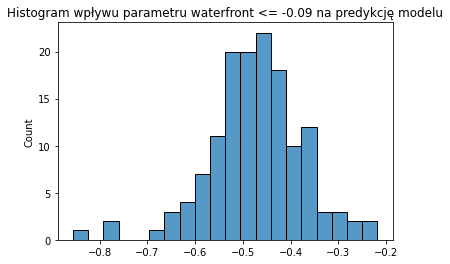

In [100]:
ax = sns.histplot(exp_dict[keys[1]], bins=20).set_title('Histogram wpływu parametru {} na predykcję modelu'.format(keys[1]))

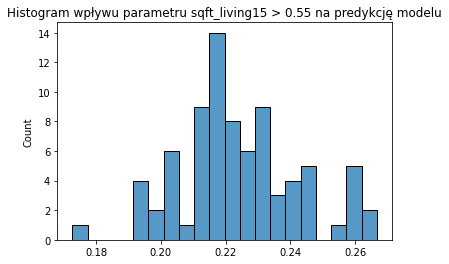

In [101]:
ax = sns.histplot(exp_dict[keys[2]], bins=20).set_title('Histogram wpływu parametru {} na predykcję modelu'.format(keys[2]))

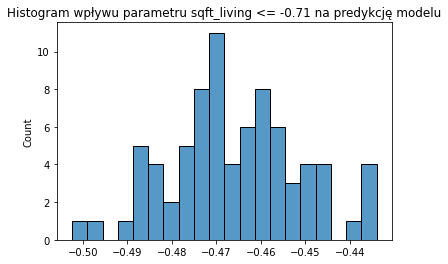

In [102]:
ax = sns.histplot(exp_dict[keys[3]], bins=20).set_title('Histogram wpływu parametru {} na predykcję modelu'.format(keys[3]))

Żeby zbadać stabilność wyjaśnienia trzeba sprawdzić, czy znieznaczna zmiana jakiegoś parametru nie sprawi, że model wygenerowany przez LIME'a nie będzie znacznie inny. W tym celu użyto dekompozycji LIME dla pierwszej obserwacji oraz dla zmodyfikowanej pierwszej obserwacji.

Najpierw bez modyfikacji:

,sqft_living,grade,lat,view,sqft_living15
0,-0.719715,-0.572104,1.171651,-0.304238,-0.819925


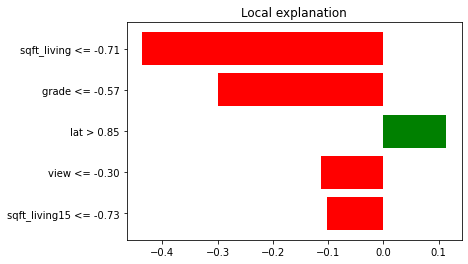

In [103]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)
obs = train_x.loc[0]
exp = explainer.explain_instance(obs, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(obs[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

,grade,sqft_living,view,lat,sqft_living15
0,-0.572104,-0.619715,-0.304238,1.171651,-0.819925


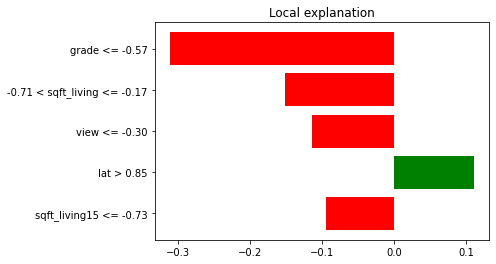

In [104]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

obs_mod = obs.copy()
obs_mod['sqft_living'] += 0.1
exp = explainer.explain_instance(obs_mod, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)

exp.as_pyplot_figure()
pd.DataFrame(obs_mod[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Powyżej dekompozycja dla tej samej obserwacji, ale z trochę zmienioną wartością sqft_living (tak, żeby przeszła do innej kategorii; wtedy była w kategori sqft_living <=-0.71, a teraz jest w -0.71< sqft_living <=-0.17). Jak widać parametry dekompozycji są bardzo podobne.

,grade,view,lat,sqft_living15,sqft_living
0,-0.572104,-0.304238,1.171651,-0.819925,0.280285


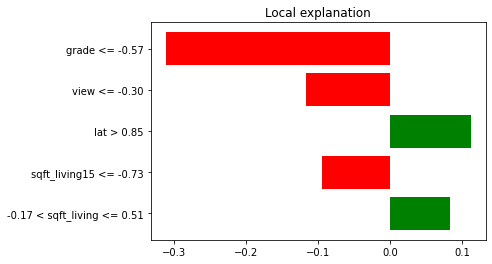

In [105]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

obs_mod = obs.copy()
obs_mod['sqft_living'] += 1
exp = explainer.explain_instance(obs_mod, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(obs_mod[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Nawet po sporej zmianie sqft_living (o 1) pozostałe parametry wyjaśnienia zmieniły się tylko nieznacznie.

,sqft_living,grade,lat,view,sqft_living15
0,-0.719715,-0.572104,1.171651,0.695762,-0.819925


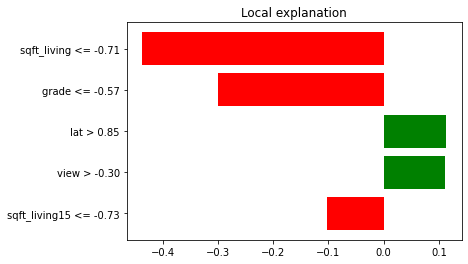

In [106]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

obs_mod = obs.copy()
obs_mod['view'] += 1
exp = explainer.explain_instance(obs_mod, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(obs_mod[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Powyżej dekompozycja dla pierwszej obserwacji ze zmodyfikownym parametrem view. Jak widać również tylko wartość dla tego parametru się zmieniła. Pozostałe wcale lub tylko nieznacznie. Wszystko wskazuje na to, że wyjaśnienie jest stabilne (w każdym razie dla tej obserwacji).


Poniżej analogiczna analiza dla innej obserwacji. Najpier dekompozycja bez zmian:

,grade,lat,sqft_living,waterfront,sqft_living15
1,3.692435,0.540473,2.818531,-0.086355,3.249037


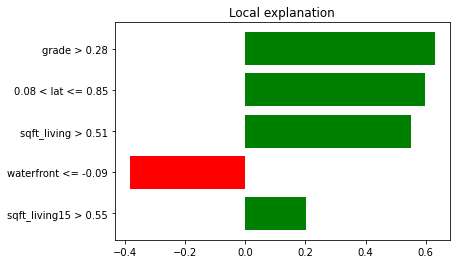

In [107]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)
obs = train_x.loc[1]
exp = explainer.explain_instance(obs, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(obs[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

A później ze zmienionymy niektórymi parametrami.

,grade,sqft_living,waterfront,sqft_living15,lat
1,3.692435,2.818531,-0.086355,3.249037,-0.459527


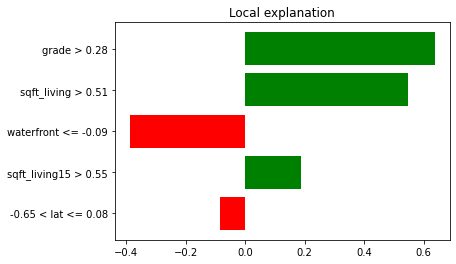

In [108]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

obs_mod = obs.copy()
obs_mod['lat'] -= 1
exp = explainer.explain_instance(obs_mod, tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(obs_mod[train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Tym razem wpływ zmienionego parametru ma trochę większę znaczenie niż poprzednio, ale pozostałe parametry wyjaśnienia się nie zmieniły.

**Komentarz**

Różne obserwacje różniły się trochę pod względem tego, który parametr miał największy wpływ. Aczkolwiek patrząc na kilkaset obserwacji wygląda na to, że te same parametry miały podobny wpływ (zarówno pod względem tego, czy działały na plus, czy na minus, ale także wartości były podobne, co obrazują histogramy pokazane wcześniej).

Wygląda również na to, że wyjaśnienie tego modelu jest stabilne. To znaczy małe zmiany parametru obserwacji zmieniały tylko nieznacznie model wygenerowany przez metodę LIME.

# 5. Wytrenowanie drugiego modelu i znalezienie obserwacji różniącej się dla modeli

In [109]:
from sklearn.svm import SVR

svm_regressor = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
svm_regressor.fit(train_x, train_y)

print('Współczynnik determinacji dla zbiory treningowego {}'.format(svm_regressor.score(train_x, train_y)))
print('Współczynnik determinacji dla zbiory walidacyjnego {}'.format(svm_regressor.score(val_x, val_y)))
print('Współczynnik determinacji dla zbiory testowego {}'.format(svm_regressor.score(test_x, test_y)))

Współczynnik determinacji dla zbiory treningowego 0.939283953971495
Współczynnik determinacji dla zbiory walidacyjnego 0.7984580157052511
Współczynnik determinacji dla zbiory testowego 0.7985283399053899


Drugim nauczonym modelem jest maszyna wektorów wspierających. Jak widać ma ona o trochę niższy współczynnik determinacji. Ale prawdopodobnie jej predykcje mają wystarczająco sensu, żeby analizować ją metodą lime.

Poniżej dekomopozycja dla jednej z obserwacji.

,waterfront,grade,lat,view,sqft_living15
0,-0.086355,-0.572104,1.171651,-0.304238,-0.819925


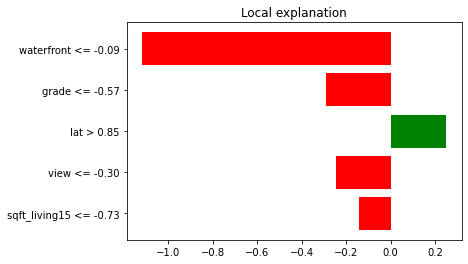

In [110]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

exp = explainer.explain_instance(train_x.loc[0], svm_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(train_x.loc[0, train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Postanowiono znaleźć obserwacje, których dekompozycje możliwie najbardziej różnią się od siebie.

In [111]:
most_diff_id = 0
shortest_len = 5
for id in train_x.index[100:110]:
  explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)
  exp1 = explainer.explain_instance(train_x.loc[0], tree_regressor.predict, num_features=5)
  exp2 = explainer.explain_instance(train_x.loc[0], svm_regressor.predict, num_features=5)
  e1_set = set([el[0] for el in exp1.as_list()])
  e2_set = set([el[0] for el in exp2.as_list()])
  if len(e1_set.intersection(e2_set)) < shortest_len:
    most_diff_id = id
    shortest_len = len(e1_set.intersection(e2_set))
    if e1_set.intersection(e2_set)==set():
      break

,waterfront,lat,grade,view,condition
100,-0.086355,-0.766038,-0.572104,-0.304238,-0.629889


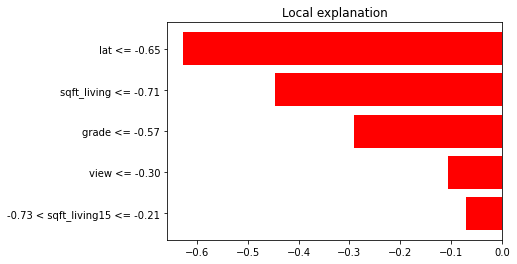

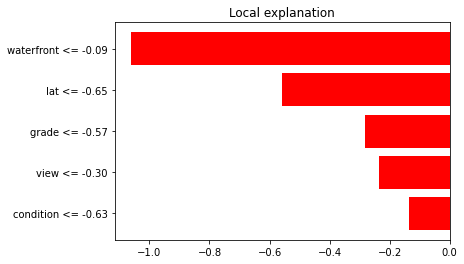

In [112]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

exp = explainer.explain_instance(train_x.loc[most_diff_id], tree_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(), feature_names=train_x.columns, class_names=['price'], verbose=False, discretize_continuous=True, mode='regression', random_state=0)

exp = explainer.explain_instance(train_x.loc[most_diff_id], svm_regressor.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
pd.DataFrame(train_x.loc[most_diff_id, train_x.columns[[el[0] for el in exp.as_map()[0]]]]).transpose()

Powyżej dekompozycja metodą LIME dla tej samej obserwacji i dwóch różnych modeli

**Komentarz**

Jak widać mimo tych samych danych wejściowych (i bardzo podobnej predykcji) te dwa modele biorą pod uwagę inne rzeczy. Dla modelu drzewiastego największy wpływ miała szerokość geograficzna, a dla SVMa to czy mieszkanie wychodzi na nabrzeże (waterfront). Pierwszy model uwzględniał również powierzchnie mieszkania, a drugi nie. Za to obydwa modele biorą pod uwagę dla tej obserwacji grade oraz view.